# Courbes de niveau

## Table des matières

- Préambule

  - Dépendances logicielles

  - Différentiation automatique

- Ensembles de niveau : exemples de référence

- Construction des courbes de niveau

  - Méthode de Newton

  - Génération des points

  - Bouclage et auto-intersection 

- Calcul de l'aire d'un ensemble de sous-niveau

  - Méthode des carrés

  - Méthodes des triangles

## Préambule

### Dépendances logicielles 

In [1]:
# Autograd & Numpy
import autograd
import autograd.numpy as np

# Pandas
import pandas as pd

# Matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [5, 5] # [width, height] (inches). 

# Jupyter & IPython
from IPython.display import display

### Différentation automatique

On définit ici deux fonctions utilitaires, `grad` et `J`, permettant de calculer simplement le gradient d'une fonction scalaire de deux variables réelles et la matrice jacobienne d'une fonction vectorielle de deux variables réelles.

In [2]:
def grad(f):
    g = autograd.grad
    def grad_f(x, y):
        return np.array([g(f, 0)(x, y), g(f, 1)(x, y)])
    return grad_f

In [3]:
def J(f):
    j = autograd.jacobian
    def J_f(x, y):
        return np.array([j(f, 0)(x, y), j(f, 1)(x, y)]).T
    return J_f

Exemples d'usage :

In [4]:
def f(x, y):
    return np.sin(x) + 2.0 * np.sin(y)

grad_f = grad(f)

grad_f(1.0, 0.0) # array([1., 2.])
#g = autograd.grad
#print(g(f,0)(0.0,0.0))

array([0.54030231, 2.        ])

In [5]:
def f(x, y):
    return np.array([x + 2 * y, 3 * x + 4 * y])

J_f = J(f)

J_f(0.0, 0.0) # array([[1., 2.], [3., 4.]])

array([[1., 2.],
       [3., 4.]])

## Ensembles de niveau : exemples de référence

On appelle *ensemble de niveau* $c \in \mathbb{R}$ d'une fonction $f : \mathbb{R}^2 \to \mathbb{R}$  l'ensemble du plan
$$
\{(x,y) \in \mathbb{R}^2 \; | \; f(x, y) = c\}.
$$


On définit ici quelques fonctions qui pourront servir de référence pour valider les algorithmes de génération de courbes de niveau. On pourra également utiliser la fonction utilitaire `display_contour` ci-dessous, qui exploite [la fonction `contour` de Matplotlib](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.contour.html) pour représenter une collection d'ensembles de niveau.

In [6]:
def display_contour(f, x, y, levels):
    X, Y = np.meshgrid(x, y)
    Z = f(X, Y)
    fig, ax = plt.subplots()
    contour_set = plt.contour(
        X, Y, Z, colors="grey", linestyles="dashed", 
        levels=levels 
    )
    ax.clabel(contour_set)
    plt.grid(True)
    plt.xlabel("$x_1$") 
    plt.ylabel("$x_2$")
    plt.gca().set_aspect("equal")

#### Fonction quadratique

In [7]:
def f1(x, y):
    x = np.array(x)
    y = np.array(y)
    return 3.0 * x * x - 2.0 * x * y + 3.0 * y * y 

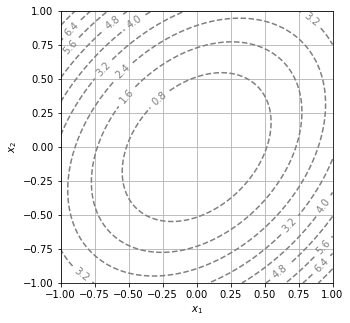

In [8]:
display_contour(
    f1, 
    x=np.linspace(-1.0, 1.0, 100), 
    y=np.linspace(-1.0, 1.0, 100), 
    levels=10 # 10 levels, automatically selected
)

#### Fonction de Rosenbrock

Source : [Fonction de Rosenbrock, Wikipédia](https://en.wikipedia.org/wiki/Rosenbrock_function)

$$
f_2 : (x,y) \in \mathbb{R}^2 \mapsto (x - 1)^2 + (x - y^2)^2
$$

In [9]:
def f2(x, y):
    return (x - 1)**2 + (x - y**2)**2

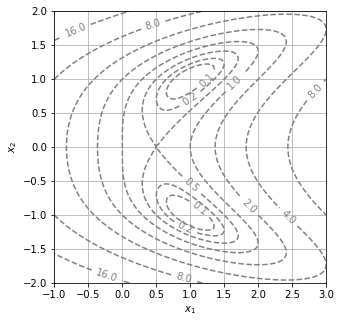

In [10]:
display_contour(
    f2, 
    x=np.linspace(-1.0, 3.0, 100), 
    y=np.linspace(-2.0, 2.0, 100), 
    levels=[2**i for i in range(-3, 8)] # levels: [0.125, 0.25, ..., 64, 128]
)

#### Fonction complexe

Source: [Courbe implicite, Wikipédia](https://en.wikipedia.org/wiki/Implicit_curve)

In [11]:
def f3(x, y):
    return np.sin(x + y) - np.cos(x * y) - 1 + 0.001 * (x * x + y * y) 

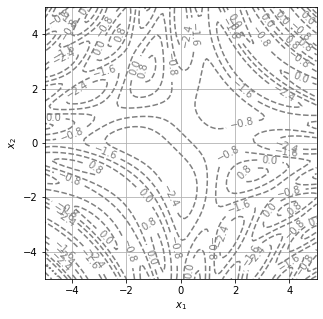

In [12]:
display_contour(
    f3, 
    x=np.linspace(-5.0, 5.0, 100), 
    y=np.linspace(-5.0, 5.0, 100), 
    levels=5, # 5 levels, automatically selected
)

## Construction des courbes de niveau

### Méthode de Newton

Afin de trouver des points sur des courbes de niveau, on souhaite implémenter un algorithme de résolution des équations de la forme $F(x,y) = 0$ où $F: \mathbb{R}^2 \to \mathbb{R}^2$, par la méthode de Newton, amorcée par un point de référence $(x_0,y_0) \in \mathbb{R}^2$.

L'implémentation prendra la forme générale donnée ci-dessous. L'appel `x, y = Newton(F, x0, y0, eps, N)` devra renvoyer le couple des coordonnées d'un point $(x, y)$ qui est une solution approchée de $F(x,y)=0$ à proximité de $(x_0, y_0)$. La qualité de l'approximation produite est déterminée par le réel positif $\varepsilon > 0$, une approximation de la distance entre le point $(x,y)$ renvoyé par la fonction et la solution exacte. L'algorithme itératif s'interrompra si aucune approximation de la précision souhaitée n'a été trouvée en $N$ étapes. 

**Question** L'application à laquelle nous destinons la fonction `Newton` demande-t'elle une grande précision ?
Choisir une valeur de `eps` qui semble raisonnable et justifier l'ordre de grandeur choisi.

In [13]:
N = 100
eps = 0.01

# L'application à laquelle nous destinons Newton ne demande pas une précision trop importante. 
# En vérifiant les résultats ci-dessous pour différentes valeurs de eps, on remarque que passer 
# de 0.1 à 0.001 n'entraîne pas de changements importants.

**Question** Implémenter la fonction `Newton` en complétant le canevas ci-dessous

In [14]:
def Newton(F, x0, y0, eps=eps, N=N):
    X = np.array([x0,y0]) 
    for i in range(N):
        Xn = X - np.dot(np.linalg.inv(J(F)(X[0],X[1])),F(X[0],X[1]))
        if np.sqrt((Xn[0] - X[0])**2 + (Xn[1] - X[1])**2) <= eps:
            return Xn[0], Xn[1]
        X[0], X[1] = Xn[0], Xn[1]
    else:
        raise ValueError(f"no convergence in {N} steps.")

# On commence en (x0, y0). A chaque itération, on approxime la fonction F au voisinage de (x,y)
# obtenu précédemment à l'aide de la définition de la différentielle/jacobienne. Le nouveau point
# est alors le zéro de l'approximation de F (dont on suppose la différentielle inversible près de (x,y)).
# Newton renvoie un résultat lorsque les points successifs sont proches à moins de eps > 0.

**Question** Tester votre implémentation de la fonction `Newton` ! On suggère par exemple de l'utiliser pour chercher un point $(x, y)$ de la ligne de niveau $0.8$ de $f_1$ (cf. Exemples de référence) qui vérifie en outre $x = y$ en utilisant le point $(0.8, 0.8)$. Puis de faire varier le point de référence, la contrainte supplémentaire, etc. et de représenter graphiquement les résultats.

(0.447250250297228, 0.447250250297228)


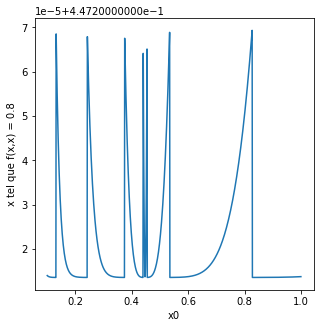

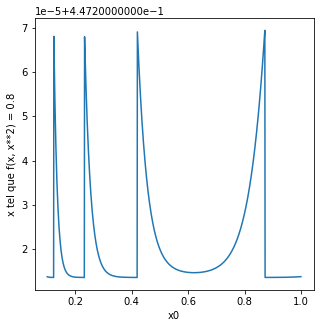

In [15]:
def h(x,y):
    return np.array([f1(x,y) - .8, x - y])

# Les zéros de h : R^2 -> R^2 obtenus à l'aide de Newton donnent la ligne de niveau de 0.8 de f1 vérifiant x = y.

print(Newton(h,.8,.8,eps,N))

def Newt(x):
    return Newton(h,x,x,eps,N)[0]

Newt = np.vectorize(Newt)
X = np.linspace(0.1,1,1000)
Y = Newt(X)
plt.xlabel("x0")
plt.ylabel("x tel que f(x,x) = 0.8")
plt.plot(X,Y)
plt.show()

# On trace la valeur de x dans la ligne de niveau de 0.8 de f1 vérifiant x = y 
# en fonction des points initiaux (x0, x0).

def h1(x,y):
    return np.array([f1(x,y) - .8, x - y])

# On peut aussi faire varier la contrainte. Ici on considère la ligne de niveau de 0.8 de f1 satisfaisant y = x ** 2.

def Newt1(x):
    return Newton(h,x,x ** 2,eps,N)[0]

Newt1 = np.vectorize(Newt1)
X1 = np.linspace(0.1,1,1000)
Y1 = Newt1(X1)
plt.xlabel("x0")
plt.ylabel("x tel que f(x, x**2) = 0.8")
plt.plot(X1,Y1)
plt.show()

### Génération des points

**Question** Comment, en partant d'un point de référence $(x_0, y_0)$ tel que $f(x_0, y_0)=c$, peut-on générer avec la méthode de Newton un point $(x_1, y_1)$ également tel que $f(x_1, y_1) = c$, mais à une distance $\delta > 0$ de $(x_0, y_0)$ et qui soit "à droite" quand on est en $(x_0, y_0)$ et qu'on regarde dans la direction de $\nabla f(x_0, y_0)$ ? Implémenter la fonction `level_curve` qui répète ce procédé $N-1$ fois et renvoie un tableau NumPy de taille $2 \times N$ contenant les coordonnées des points correspondants.

In [16]:
def level_curve(f,x0,y0,delta=0.1,N=1000,eps=eps):
    def step(u): # on calcule un vecteur unitaire orthogonal au gradient et à sa droite
        return np.array([u[1],-u[0]])/np.sqrt(u[0] ** 2 + u[1] ** 2)
    c = f(x0,y0)
    x, y = x0, y0
    def foo(h1,h2): # on appliquera Newton à une fonction de R^2 dans R^2 qui encode la contrainte et le fait d'appartenir à la courbe de niveau
        return np.array([f(x + h1, y + h2) - c, h1**2 + h2**2 - delta ** 2])
    tab = np.zeros((2,N))
    for i in range(N):
        tab[0,i] = x
        tab[1,i] = y
        H = Newton(foo, step(grad(f)(x,y))[0] * delta, step(grad(f)(x,y))[1] * delta, eps, N) # on se met à une distance delta
        x, y = x + H[0], y + H[1]
    return tab

### Bouclage et auto-intersection

L'algorithme précédent est malheureusement susceptible de faire plusieurs fois le tour d'une courbe de niveau donnée. 

**Question** Proposer une nouvelle implémentation de `level_curve` qui évite ce problème. 

In [17]:
def level_curve1(f,x0,y0,delta=0.1,N=1000,eps=eps):
    def step(u):
        return np.array([u[1],-u[0]])/np.sqrt(u[0] ** 2 + u[1] ** 2)
    c = f(x0,y0)
    x, y = x0, y0
    def foo(h1,h2):
        return np.array([f(x + h1, y + h2) - c, h1**2 + h2**2 - delta ** 2])
    tab = np.zeros((2,N))
    tab[0,0] = x0
    tab[1,0] = y0
    H = Newton(foo, step(grad(f)(x0,y0))[0] * delta, step(grad(f)(x0,y0))[1] * delta, eps, N)
    x, y = x0 + H[0], y0 + H[1]
    for i in range(1,N):
        if (x - x0)**2 + (y - y0)**2 > delta ** 2 or (grad(f)(x,y)[0] - grad(f)(x,y)[0])**2 + (grad(f)(x,y)[1] - grad(f)(x,y)[1])**2 > delta **2:
            tab[0,i] = x
            tab[1,i] = y
            H = Newton(foo, step(grad(f)(x,y))[0] * delta, step(grad(f)(x,y))[1] * delta, eps, N)
            x, y = x + H[0], y + H[1]
        else:
            #tab[0,i] = x0 # on peut rajouter le point initial à la fin du tableau pour que les points se rejoignent
            #tab[1,i] = y0 # mais cela n'est pas nécessaire pour les calculs d'aires.
            tab = tab[:,:i]
            break
    return tab

# on considère qu'on a fait un tour lorsque f au point considéré est suffisamment proche de f(x0,y0)
# et que les gradient est suffisamment proche de grad(f)(x0,y0).

**Question** Valider graphiquement le résultat au moyen des exemples de référence.

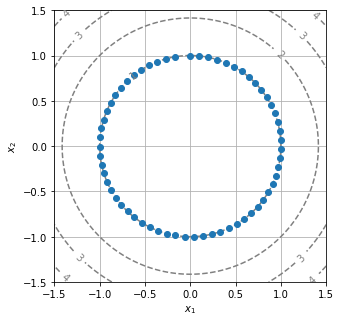

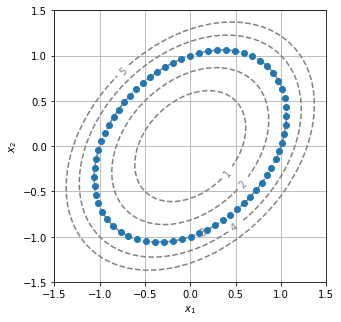

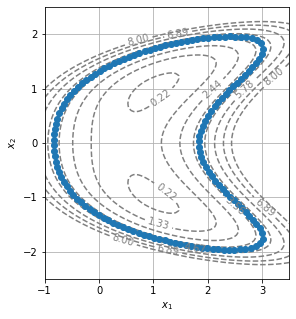

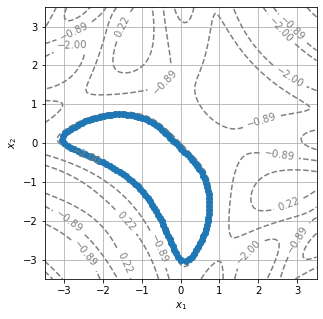

In [18]:
def cercle(x,y):
    return x ** 2 + y ** 2

# fonction dont les courbes de niveau sont des cercles.

tab = level_curve1(cercle, 0.0, 1.0)

display_contour(cercle, x=np.linspace(-1.5, 1.5, 100), y=np.linspace(-1.5, 1.5, 100), levels=np.linspace(0, 5, 6))
plt.plot(tab[0], tab[1], 'o')

#f1

tab = level_curve1(f1, 0.0, 1.0)

display_contour(f1, x=np.linspace(-1.5, 1.5, 100), y=np.linspace(-1.5, 1.5, 100), levels=np.linspace(0, 5, 6))
plt.plot(tab[0], tab[1], 'o')

#f2

tab = level_curve1(f2, 2.0, 0.5)

display_contour(f2, x=np.linspace(-1.0, 3.5, 100), y=np.linspace(-2.5, 2.5, 100), levels=np.linspace(-2, 8, 10))
plt.plot(tab[0], tab[1], 'o')

#f3

tab = level_curve1(f3, 0.,-3. )

display_contour(f3, x=np.linspace(-3.5, 3.5, 100), y=np.linspace(-3.5, 3.5, 100), levels=np.linspace(-2, 8, 10))
plt.plot(tab[0], tab[1], 'o')

# Calcul de l'aire d'un ensemble de sous-niveau
On cherche à estimer l'aire d'un ensemble délimité par une courbe fermée, approchée par une ligne brisée comme les ensemble de niveau décrits précédemment.

## Méthode des carrés
Considérons un tel ensemble $K$ décrit par l'équation $f(x_1,x_2)\leq c$.
Une première approche grossière, sans utiliser la description de la frontière obtenue précédemment, consiste à plonger l'ensemble  $K$ dans un domaine de forme simple (disons un carré pour fixer les idées), donc d'aire connue, à recouvrir le carré d'une grille uniforme constituée de petites cellules carrée de taille $h\times h$,  et d'estimer l'aire en fonction de la proportion du nombre de cellules dont le centre est  dans $K$. On obtient ainsi une approximation $A_h$ de l'aire de $K$. Lorsque $h$ tend vers $0$, on peut  s'attendre à ce que $A_h$ tende effectivement vers l'aire $A$ de $K$. 

**Question**  Coder une fonction `area_squares(f,c,h)` qui renvoie l'aire approchée de l'ensemble de sous-niveau de $f$ associée à $c$ à l'aide de la méthode des carrés pour un pas $h$. Appliquer cette méthode à l'estimation  de l'aire du disque unité et étudier numériquement le comportement de  $|A_h - A|$ quand $h$ tend vers $0$. (On pourra tracer une courbe de l'erreur fonction de $h$ en échelle log-log).

3.1428000000000003


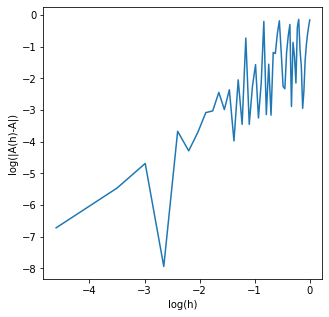

In [19]:
def area_squares(f,c,h,k):
    X = np.arange(-k,k + 1,h)
    n = len(X)
    S = 0
    for i in range(n - 1):
        for j in range(n - 1):
            if f((X[i] + X[i+1])/2,(X[j] + X[j+1])/2) <= c:
                S += 1
    return S * h ** 2

# On choisit la taille du carré couvrant, indiquée par la variable k dans la fonction area_squares. 

print(area_squares(cercle,1.0,0.01,1.1))   

# On étudie |A(h) - π| quand h -> 0 (A = π).

def error(h):
    return abs(area_squares(cercle, 1., h, 1.1) - np.pi)

error = np.vectorize(error)

x = np.linspace(0.01,1,50)
y = error(x)
plt.xlabel("log(h)")
plt.ylabel("log(|A(h)-A|)")
plt.plot(np.log(x), np.log(y))
plt.show()

# On a bien un logarithme qui semble tendre vers -∞, donc une différence qui tend vers 0.

**Question**  Expliquer comment cette approche peut être modifiée pour obtenir un encadrement de l'aire recherchée. 
Appliquer cette approche à l'ensemble de sous niveau considéré précédemment, pour en donner un encadrement à $10^{-2}$ près.


In [20]:
# La majoration est donnée par area_squares. On peut minorer l'aire en renforçant la condition d'appartenance d'un
# carré donné à la surface étudiée. Par exemple, on peut considérer un carré dans la surface lorsque tous ses sommets
# appartiennent à celle-ci. Cette conditions étant plus contraignante, on a bien 
# une minoration.

def area_squares1(f,c,h,k):
    X = np.arange(-k,k*h + 1,h)
    n = len(X)
    S = 0
    for i in range(n - 1):
        for j in range(n - 1):
            if f(X[i],X[j]) <= c and f(X[i+1],X[j]) <= c and f(X[i],X[j+1]) <= c and f(X[i+1],X[j+1]) <= c:
                S += 1
    return S * h ** 2

print(area_squares(cercle,1.0,0.01,1.1)) 

print(area_squares1(cercle,1.0,0.01,1.1))

# On peut jouer sur la précision en jouant sur h (10e-2 ici).

3.1428000000000003
3.1004


## Méthode des triangles
On suppose maintenant que l'on dispose d'une description approchée de la frontière de l'ensemble $K$, sous la forme d'une suite "circulaire"  de points consécutifs:
$$
(x_0,y_0), (x_1,y_1), \dots, (x_N,y_N)= (x_0,y_0),
$$
par exemple la sortie de ``level_curve``.
On note $z_i = (x_i,y_i)$. Conformément à ce qui précède, on considére que la courbe fermée est décrite dans le sens anti-trigonométrique (sens des aiguilles d'une montre). On suppose dans un premier temps que l'ensemble $K$ est convexe. 
On se donne un point $p = (x_p,y_p)$ dans  l'intérieur de $K$, et l'on somme les aires des triangles $(p,z_{i+1},z_i)$. 
On obtient une approximation de l'aire de $K$, notée $B_N$.

**Question** Tester cette approche sur le disque unité. Etudier la convergence de $B_N$ vers $\pi$ lorsque la distance $\delta$ entre les points successifs de la courbe de niveau tend vers 0, et étudier numériquement la vitesse de cette convergence.  

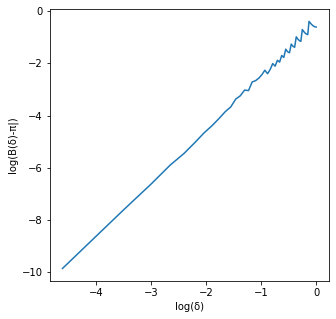

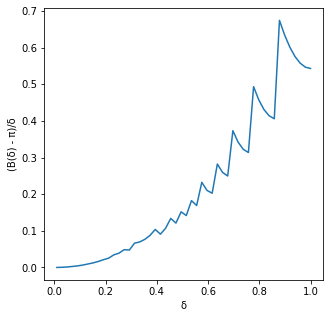

In [21]:
def shoelace_triangle(p1, p2, p3):
    return -0.5*((p1[0]*p2[1] + p2[0]*p3[1] + p3[0]*p1[1] - p2[0]*p1[1] - p3[0]*p2[1] - p1[0]*p3[1]))

# On calcule l'aire du parallélogramme engendré par deux vecteurs 
# à l'aide du produit vectoriel, puis on divise par deux 
# pour obtenir l'aire d'un triangle (shoelace formula en anglais).
# Le calcul dépend du sens de lecture des points. Les points
# de la courbe de niveau pour le cercle sont donnés dans le sens horaire. 
# Dans le sens horaire on a un signe -, d'où le signe - dans le résultat retourné. 

def area_triangle(delta,centre):
    test = level_curve1(cercle, 0.0, 1.0, delta = delta)
    area = 0
    for i in range(0, len(test[0])-1):
        a1, a2 = test[0,i], test[1,i]
        b1, b2 = test[0,i+1], test[1,i+1]
        current_area = shoelace_triangle(centre, (a1,a2), (b1,b2))
        area += current_area
    area += shoelace_triangle(centre, (test[0,-1], test[1,-1]), (test[0,0], test[1,0]))
    return area

# on itère shoelace_triangle pour deux points successifs et le point choisi.
# on distingue le cas où on revient au point initial.

def error(d):
    return abs(area_triangle(d,(0,0)) - np.pi)

error = np.vectorize(error)

x = np.linspace(0.01,1,50)
y = error(x)
plt.xlabel("log(δ)")
plt.ylabel("log(B(δ)-π|)")
plt.plot(np.log(x),np.log(y))
plt.show()

# Le tracé suggère que B(δ) = π + o(δ) quand δ -> 0.
# Vérifions que (B(δ) - π)/δ = o(1).

def error1(d):
    return abs(area_triangle(d,(0,0)) - np.pi)/d

error1 = np.vectorize(error1)

x = np.linspace(0.01,1,50)
y = error(x)
plt.xlabel("δ")
plt.ylabel("(B(δ) - π)/δ")
plt.plot(x,y)
plt.show()

# On a bien B(δ) = π + o(δ). 
# Donc la vitesse de convergence est linéaire.

**Question** Vérifier que l'approche (on prendra garde à accepter le fait qu'il puisse y avoir, dans le calcul des différentes aires,  des triangles d'aire négative) donne des résultats pertinents même si le point $p$ est  à l'extérieur de $K$. Donner une explication à ce bon comportement.

In [22]:
print(area_triangle(0.01, (-42, 33)))

# Si les points sont lus dans le sens trigonométrique (resp. anti-trigonométrique) alors
# l'aire correspondante est comptée négativement (resp. positivement) dans l'implémentation
# donnée plus haut. Si un point est à l'extérieur du cercle unité, par exemple en initialisant
# level_curves à (0,1) et en parcourant le cercle dans le sens horaire, on aura des aires négatives
# jusqu'à ce qu'une droite rejoignant le point de référence et le cercle coupe ce-dernier en deux points.
# Ensuite les aires sont comptées positivement et il y a compensation des triangles plus grands qui
# sortent du cercle unité.

3.141540222561215


**Question** Vérifier le bon comportement de la méthode dans le cas où l'ensemble $K$ n'est pas convexe. On pourra considérer par exemple la réunion de deux disques, tous deux décrits par leur frontière discrétisée parcourue dans le sans anti-trigonométrique.

4.131024138449124


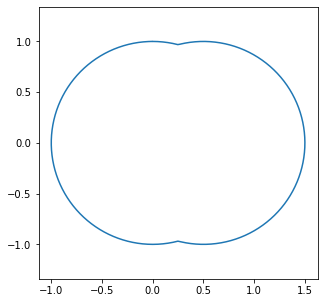

In [23]:
def disque_reunion(x,y):
    if x < 0.25:
        res = x**2 + y**2
    else:
        res = (x - 0.5)**2 + y**2
    return res

union = level_curve1(disque_reunion, 0.,1.,delta = 0.01)

plt.plot(union[0],union[1])
plt.axis("equal")

def area_triangles1(delta,centre):
    area = 0
    for i in range(0, len(union[0])-1):
        a1, a2 = union[0,i], union[1,i]
        b1, b2 = union[0,i+1], union[1,i+1]
        current_area = shoelace_triangle(centre, (a1,a2), (b1,b2))
        area += current_area
    area += shoelace_triangle(centre, (union[0,-1], union[1,-1]), (union[0,0], union[1,0]))
    return area

print(area_triangles1(0.01, (0, 2)))

# On peut vérifier le résultat par un calcul d'intégrale (lien ci-dessous).
# https://www.wolframalpha.com/input/?i=2*%28integral+from+-1+to+0.25+sqrt%281-x%5E2%29+%2B+integral+from+0.25+to+1.5+sqrt%281-%28x-0.5%29%5E2%29%29

**Question** En déduire une fonction `area_triangles(x,y)` qui évalue l'aire d'une surface de niveau décrite par un ensemble de points $(x_i,y_i)$ de la courbe de niveau. Appliquer cette approche à l'ensemble de sous-niveau considéré précédemment, et vérifier que les deux méthodes (carrés et triangles) donnent des résultats cohérents entre elles. 
Comparer les méthodes entre elles, en précisant les avantages et défauts relatifs de chacune d'elles. 
(On pourra appuyer la réponse sur des tests numériques ainsi que sur des arguments théoriques)

In [24]:
delta = 0.01

def area_triangles(x,y):
    centre = (x,y)
    test = level_curve1(f1, 0.0, 1.0, delta = delta)
    area = 0
    for i in range(0, len(test[0])-1):
        a1, a2 = test[0,i], test[1,i]
        b1, b2 = test[0,i+1], test[1,i+1]
        current_area = shoelace_triangle(centre, (a1,a2), (b1,b2))
        area += current_area
    area += shoelace_triangle(centre, (test[0,-1], test[1,-1]), (test[0,0], test[1,0]))
    return area

print(f"Aire d'une surface de niveau de f1 selon area_triangles = {area_triangles(0.0,1.0)}")

print(f"Aire d'une surface de niveau de f1 selon area_squares = {area_squares(f1,f1(0.0,1.0),0.01,1.1)}")

# Les deux méthodes donnent des résultats cohérents. Néanmoins, il faut deviner la taille
# du carré couvrant dans area_squares alors que area_triangle part d'un point et de la fonction.
# Cependant, on doit calculer une courbe de niveau pour utiliser area_triangles. 
# Dans le cas d'une fonction pour laquelle la courbe de niveau est "compliquée", area_squares serait
# éventuellement préférable. Néanmoins, pour une courbe de niveau "simple", telle que celle définissant 
# le cercle unité, area_triangles donne une meilleure approximation.

# cercle unité

print(f"Aire du disque unité selon area_triangles = {area_triangle(0.01, (-42, 33))}") # triangle "sans s" i.e. fonction définie dans la première cellule

print(f"Aire du disque unité selon area_squares = {area_squares(cercle,1.0,0.001,1.1)}")

# Pour commencer à avoir des résultats aussi proches de π que area_triangles, il faut prendre une valeur
# de h considérablement plus petite pour area_squares, ce qui résulte en un temps d'exécution plus long.

Aire d'une surface de niveau de f1 selon area_triangles = 3.332109664060253
Aire d'une surface de niveau de f1 selon area_squares = 3.3320000000000003
Aire du disque unité selon area_triangles = 3.141540222561215
Aire du disque unité selon area_squares = 3.141676
